In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv(Path.home()/'data'/'keypoints'/'training.csv')

In [3]:
data.shape

(7049, 31)

In [4]:
img_sz = 96
np_shape = img_sz, img_sz
torch_shape = 1, img_sz, img_sz
num_of_landmarks = 30
seed = 1

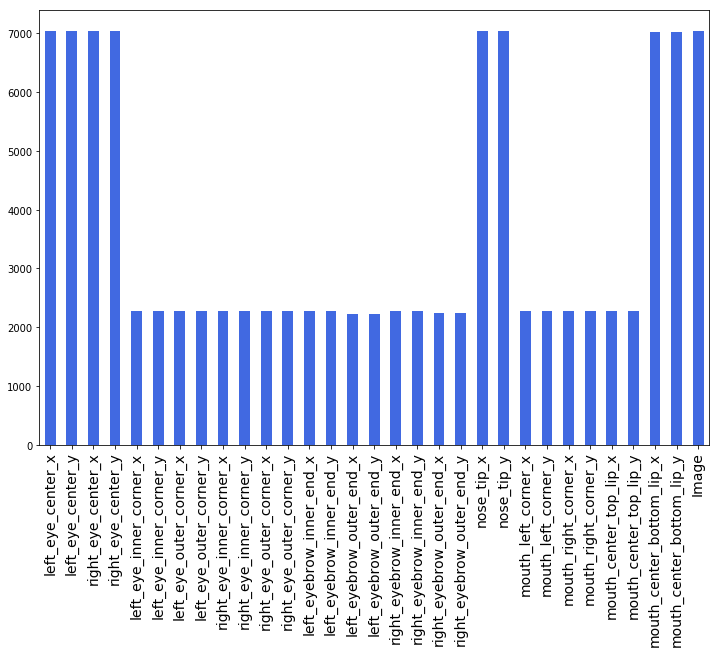

In [5]:
ax = data.count().plot.bar(color='royalblue', figsize=(12, 8))
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

In [6]:
def get(record, coord):
    return [v for k, v in record.items() if k.endswith(f'_{coord}')]

In [7]:
def create_sample(record, shape):
    return np.fromstring(record.Image, sep=' ').reshape(shape)

In [8]:
def create_target(record):
    xs, ys = [get(record, coord) for coord in ('x', 'y')]
    return np.r_[xs, ys]

In [9]:
def split(target):
    return target[:num_of_landmarks//2], target[num_of_landmarks//2:]

In [10]:
def show(df, i, ax=None, figsize=(4, 4)):
    record = df.iloc[i]
    sample = create_sample(record, np_shape)
    target = create_target(record)
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_title(f'#{i}')
    ax.imshow(sample, cmap='gray')
    ax.scatter(*split(target), color='lightgreen', edgecolor='white', alpha=0.8)
    ax.set_axis_off()

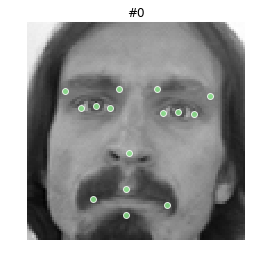

In [11]:
show(data, 0)

In [12]:
def show_random_grid(df, n=5, figsize=(10, 10), h_pad=0.05, w_pad=0.05):
    f, axes = plt.subplots(n, n, figsize=figsize)
    n_images = len(df)
    indexes = np.random.choice(n_images, size=n*n, replace=False)
    for idx, ax in zip(indexes, axes.flat):
        show(df, idx, ax=ax)
    f.tight_layout(h_pad=h_pad, w_pad=w_pad)

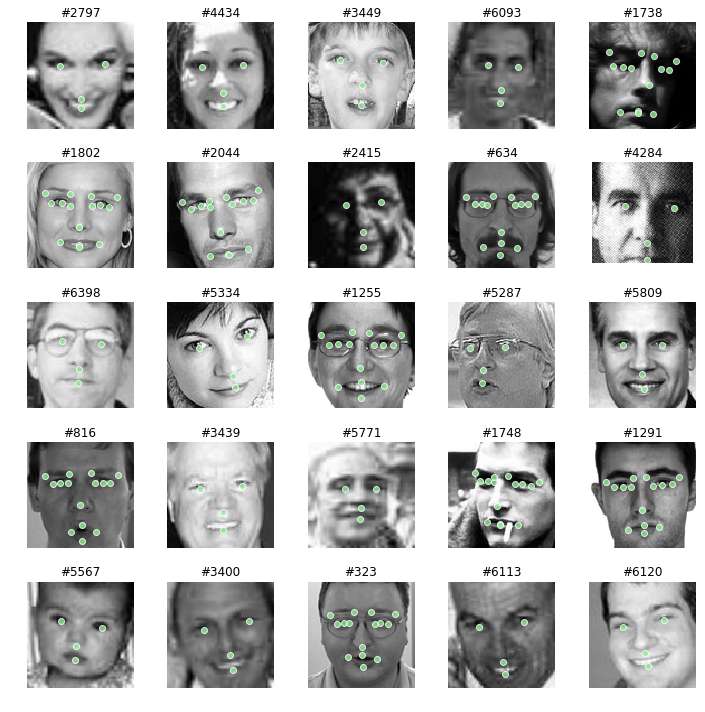

In [13]:
show_random_grid(data)

In [14]:
landmarks = data[data.columns[data.columns != 'Image']]

In [15]:
X = SimpleImputer().fit_transform(landmarks) 
imputed_data = pd.DataFrame(X, columns=landmarks.columns)
imputed_data['Image'] = data.Image

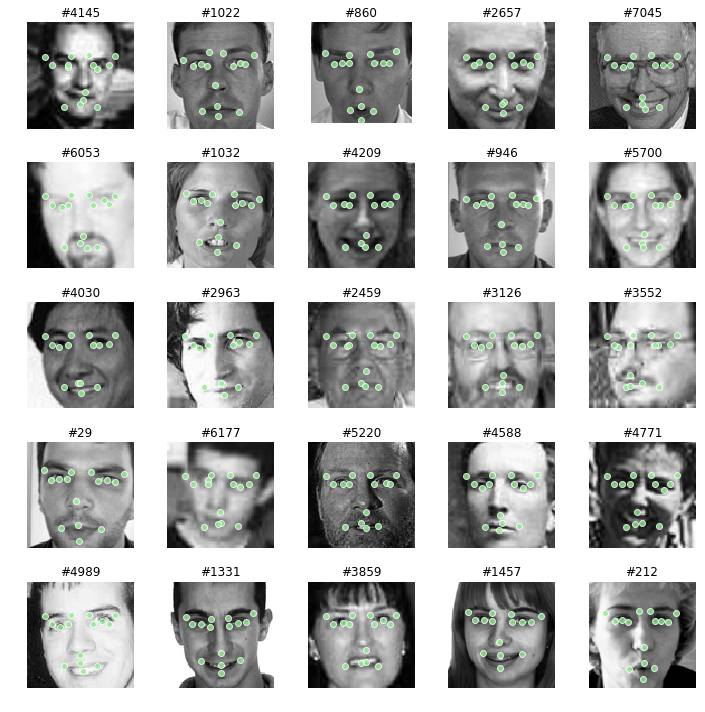

In [16]:
show_random_grid(imputed_data)

In [17]:
import copy
import math

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [18]:
X = np.stack(imputed_data.apply(lambda x: create_sample(x, torch_shape), axis=1).values)

In [19]:
y = np.stack(imputed_data.drop(columns='Image').apply(lambda x: create_target(x), axis=1).values)

In [20]:
def create_datasets(X, y, test_size=0.2):
    X_norm = X/255
    scaler = MinMaxScaler(feature_range=(-1, 1))
    y_norm = scaler.fit_transform(y)
    subsets = train_test_split(X_norm, y_norm, test_size=0.2, random_state=seed)
    X_train, X_test, y_train, y_test = [
        torch.tensor(subset, dtype=torch.float32) 
        for subset in subsets]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_test, y_test)
    return train_ds, valid_ds, scaler

In [21]:
def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl

In [22]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [23]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [24]:
class SimpleNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.conv1 = nn.Conv2d(ni, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, no)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = self.pool(x)
        x = self.fc(x.view(x.size(0), -1))
        return x

In [25]:
lr = 1e-2
wd = 1e-5
bs = 1000
n_epochs = 200
patience = 40
no_improvements = 0
jobs = 12
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

trn_ds, val_ds, scaler = create_datasets(X, y)
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=jobs)
dataset_sizes = {'train': len(trn_ds), 'val': len(val_ds)}

net = SimpleNet(1, num_of_landmarks)
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = len(trn_dl)
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase, loader in (('train', trn_dl), ('val', val_dl)):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in loader:
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/200] train: 3.4832 - val: 1.4760
loss improvement on epoch: 2
[002/200] train: 0.9967 - val: 0.8010
loss improvement on epoch: 3
[003/200] train: 0.5122 - val: 0.4899
loss improvement on epoch: 4
[004/200] train: 0.4339 - val: 0.4270
loss improvement on epoch: 5
[005/200] train: 0.3163 - val: 0.3186
loss improvement on epoch: 6
[006/200] train: 0.2911 - val: 0.3035
loss improvement on epoch: 7
[007/200] train: 0.2655 - val: 0.2922
loss improvement on epoch: 8
[008/200] train: 0.2657 - val: 0.2870
loss improvement on epoch: 9
[009/200] train: 0.2499 - val: 0.2722
loss improvement on epoch: 10
[010/200] train: 0.2507 - val: 0.2708
[011/200] train: 0.2447 - val: 0.2724
loss improvement on epoch: 12
[012/200] train: 0.2464 - val: 0.2686
loss improvement on epoch: 13
[013/200] train: 0.2433 - val: 0.2661
loss improvement on epoch: 14
[014/200] train: 0.2438 - val: 0.2649
[015/200] train: 0.2422 - val: 0.2681
[016/200] train: 0.2432 - val: 0.2657
[017/200] t

[176/200] train: 0.2121 - val: 0.2421
[177/200] train: 0.2130 - val: 0.2440
loss improvement on epoch: 178
[178/200] train: 0.2112 - val: 0.2405
[179/200] train: 0.2234 - val: 0.2526
[180/200] train: 0.2196 - val: 0.2460
[181/200] train: 0.2156 - val: 0.2463
[182/200] train: 0.2120 - val: 0.2414
[183/200] train: 0.2190 - val: 0.2542
[184/200] train: 0.2149 - val: 0.2418
[185/200] train: 0.2107 - val: 0.2434
loss improvement on epoch: 186
[186/200] train: 0.2082 - val: 0.2389
[187/200] train: 0.2093 - val: 0.2425
loss improvement on epoch: 188
[188/200] train: 0.2072 - val: 0.2377
[189/200] train: 0.2111 - val: 0.2509
[190/200] train: 0.2086 - val: 0.2384
[191/200] train: 0.2183 - val: 0.2468
[192/200] train: 0.2095 - val: 0.2392
[193/200] train: 0.2185 - val: 0.2455
[194/200] train: 0.2072 - val: 0.2382
[195/200] train: 0.2085 - val: 0.2413
loss improvement on epoch: 196
[196/200] train: 0.2048 - val: 0.2377
[197/200] train: 0.2047 - val: 0.2384
loss improvement on epoch: 198
[198/200]

In [26]:
def np_clone(t):
    return t.clone().detach().cpu().numpy()

In [27]:
def predict(model, dataset, i, img_sz=img_sz, device=device, scaler=scaler):
    test_img, test_pts = dataset[i]
    with torch.no_grad():
        [pred] = model(test_img[None].to(device))
    np_pts = np_clone(pred)
    np_pts = scaler.inverse_transform(np_pts.reshape(1, -1)).flatten()
    np_img = np_clone(test_img).transpose(1, 2, 0).reshape(96, 96)
    np_img *= 255
    np_img = np_img.astype(np.uint8)
    rescaled_test_pts = scaler.inverse_transform(test_pts.reshape(1, -1)).flatten()
    return np_pts, (np_img, rescaled_test_pts)

In [28]:
def show_predictions(model, dataset, n, figsize=(10, 10)):
    f, axes = plt.subplots(n, n, figsize=figsize)
    n_samples = len(dataset)
    indexes = np.random.choice(n_samples, size=n*n, replace=False)
    for ax, idx in zip(axes.flat, indexes):
        pred_pts, (test_img, test_pts) = predict(model, dataset, idx)
        ax.imshow(test_img, cmap='gray')
        ax.scatter(*split(test_pts), color='lightgreen', edgecolor='white', s=50, alpha=0.8, 
                   label='gt')
        ax.scatter(*split(pred_pts), color='red', marker='x', s=20, label='predicted')
        ax.set_axis_off()
    handles, labels = axes.flat[0].get_legend_handles_labels()
    f.legend(handles, labels, loc='upper center', fontsize=16)

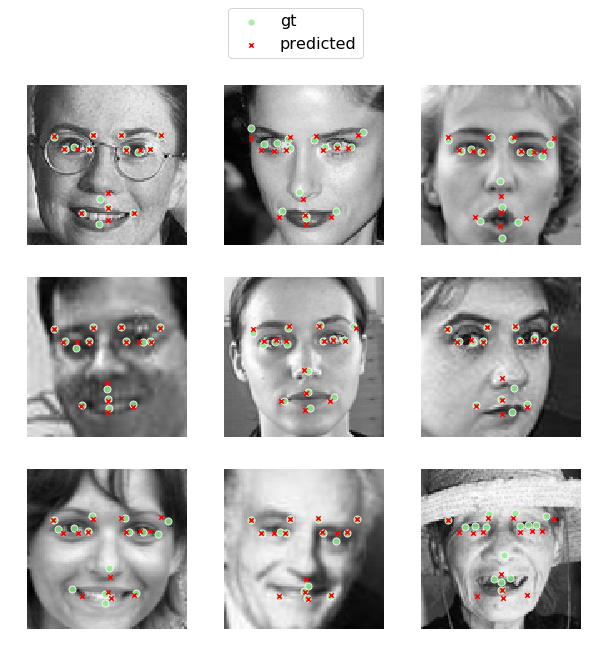

In [29]:
show_predictions(net, val_ds, 3)